(Chapter 3: Markov Dynamics)=
```{raw} jupyter
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```
# Chapter 3: Markov Dynamics


```{contents} Contents
:depth: 2
```



#### inventory_sim.py

In [1]:
import numpy as np
from scipy.stats import geom
from itertools import product
from quantecon import MarkovChain
from collections import namedtuple

# NamedTuple Model
Model = namedtuple("Model", ("S", "s", "p", "φ", "h"))

def create_inventory_model(S=100,   # Order size
                           s=10,    # Order threshold
                           p=0.4):  # Demand parameter
    φ = geom(p, loc=-1) # loc sets support to {0,1,...}
    h = lambda x, d: max(x - d, 0) + S*(x <= s)
    return Model(S=S, s=s, p=p, φ=φ, h=h)


def sim_inventories(model, ts_length=200):
    """Simulate the inventory process."""
    S, s, p, φ, h = model
    X = np.empty(ts_length)
    X[0] = S  # Initial condition
    for t in range(0, ts_length - 1):
        X[t+1] = h(X[t], φ.rvs())
    return X


def compute_mc(model, d_max=100):
    """Compute the transition probabilities and state."""
    S, s, p, φ, h = model
    n = S + s + 1  # Size of state space
    state_vals = np.arange(n)
    P = np.empty((n, n))
    for (i, j) in product(range(0, n), range(0, n)):
        P[i, j] = sum((h(i, d) == j)*φ.pmf(d) for d in range(d_max+1))
    return MarkovChain(P, state_vals)


def compute_stationary_dist(model):
    """Compute the stationary distribution of the model."""
    mc = compute_mc(model)
    return mc.state_values, mc.stationary_distributions[0]



# Plots

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.rcParams.update({"text.usetex": True, "font.size": 14})


default_model = create_inventory_model()


def plot_ts(model, fontsize=16,
                   figname="../figures/inventory_sim_1.pdf",
                   savefig=False):
    S, s, p, φ, h = model
    X = sim_inventories(model)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(X, label=r"$X_t$", linewidth=3, alpha=0.6)
    fontdict = {'fontsize': fontsize}
    ax.set_xlabel(r"$t$", fontdict=fontdict)
    ax.set_ylabel("inventory", fontdict=fontdict)
    ax.legend(fontsize=fontsize, frameon=False)
    ax.set_ylim(0, S + s + 20)

    if savefig:
        fig.savefig(figname)


def plot_hist(model, fontsize=16,
                   figname="../figures/inventory_sim_2.pdf",
                   savefig=False):
    S, s, p, φ, h = model
    state_values, ψ_star = compute_stationary_dist(model)
    X = sim_inventories(model, 1_000_000)
    histogram = [np.mean(X == i) for i in state_values]

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(state_values, ψ_star, "k-",  linewidth=3, alpha=0.7,
                label=r"$\psi^*$")
    ax.bar(state_values, histogram, alpha=0.7, label="frequency")
    fontdict = {'fontsize': fontsize}
    ax.set_xlabel("state", fontdict=fontdict)

    ax.legend(fontsize=fontsize, frameon=False)
    ax.set_ylim(0, 0.015)

    if savefig:
        fig.savefig(figname)

In [2]:
model = create_inventory_model()

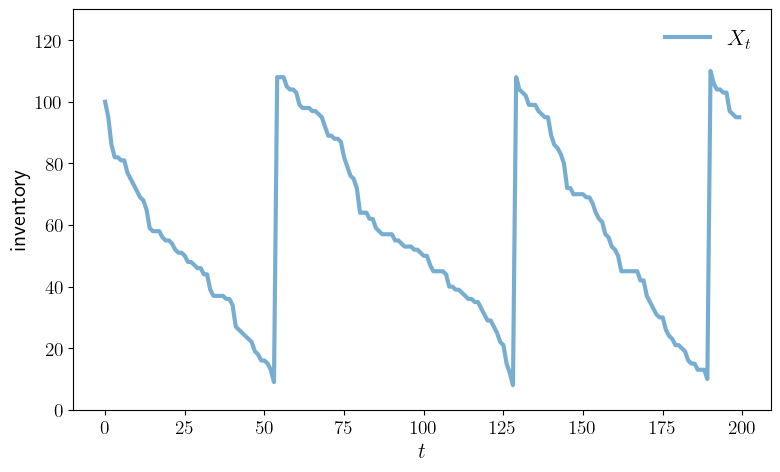

In [3]:
plot_ts(model, savefig=True)

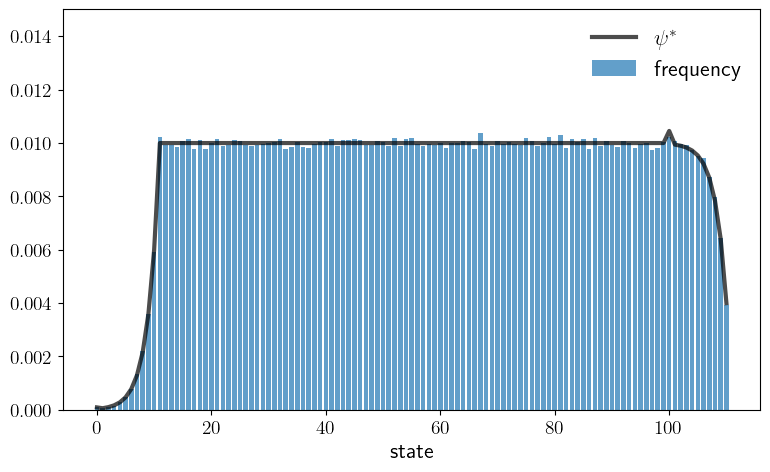

In [4]:
plot_hist(model, savefig=True)

#### is_irreducible.py

In [5]:
from quantecon import MarkovChain
import numpy as np

P = np.array([
    [0.1, 0.9],
    [0.0, 1.0]
])

mc = MarkovChain(P)
print(mc.is_irreducible)

False


#### laborer_sim.py

In [6]:
import numpy as np
from collections import namedtuple


# NamedTuple Model
Model = namedtuple("Model", ("α", "β"))


def create_laborer_model(α=0.3, β=0.2):
    return Model(α=α, β=β)


def laborer_update(x, model):  # update X from t to t+1
    if x == 1:
        x_ = 2 if np.random.rand() < model.α else 1
    else:
        x_ = 1 if np.random.rand() < model.β else 2
    return x_


def sim_chain(k, p, model):
    X = np.empty(k)
    X[0] = 1 if np.random.rand() < p else 2
    for t in range(0, k-1):
        X[t+1] = laborer_update(X[t], model)
    return X


def test_convergence(k=10_000_000, p=0.5):
    model = create_laborer_model()
    α, β = model
    ψ_star = (1/(α + β)) * np.array([β, α])
    X = sim_chain(k, p, model)
    ψ_e = (1/k) * np.array([sum(X == 1), sum(X == 2)])
    error = np.max(np.abs(ψ_star - ψ_e))
    approx_equal = np.allclose(ψ_star, ψ_e, rtol=0.01)
    print(f"Sup norm deviation is {error}")
    print(f"Approximate equality is {approx_equal}")

#### markov_js.py

In [7]:
"""
Infinite-horizon job search with Markov wage draws.

"""

from quantecon.markov import tauchen
import numpy as np
from collections import namedtuple
from s_approx import successive_approx


# NamedTuple Model
Model = namedtuple("Model", ("n", "w_vals", "P", "β", "c"))

def create_markov_js_model(
        n=200,       # wage grid size
        ρ=0.9,       # wage persistence
        ν=0.2,       # wage volatility
        β=0.98,      # discount factor
        c=1.0        # unemployment compensation
    ):
    """
    Creates an instance of the job search model with Markov wages.
    """
    mc = tauchen(n, ρ, ν)
    w_vals, P = np.exp(mc.state_values), mc.P
    return Model(n=n, w_vals=w_vals, P=P, β=β, c=c)


def T(v, model):
    """
    The Bellman operator Tv = max{e, c + β P v} with e(w) = w / (1-β).
    """
    n, w_vals, P, β, c = model
    h = c + β * np.dot(P, v)
    e = w_vals / (1 - β)
    return np.maximum(e, h)


def get_greedy(v, model):
    """Get a v-greedy policy."""
    n, w_vals, P, β, c = model
    σ = w_vals / (1 - β) >= c + β * np.dot(P, v)
    return σ



def vfi(model):
    """Solve the infinite-horizon Markov job search model by VFI."""
    v_init = np.zeros(model.w_vals.shape)
    v_star = successive_approx(lambda v: T(v, model), v_init)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star



# == Policy iteration == #


def get_value(σ, model):
    """Get the value of policy σ."""
    n, w_vals, P, β, c = model
    e = w_vals / (1 - β)
    K_σ = β * ((1 - σ) * P.T).T
    r_σ = σ * e + (1 - σ) * c
    I = np.identity(K_σ.shape[0])
    return np.linalg.solve((I - K_σ), r_σ)


def policy_iteration(model):
    """
    Howard policy iteration routine.
    """
    σ = np.zeros(model.n, dtype=bool)
    i, error = 0, True
    while error:
        v_σ = get_value(σ, model)
        σ_new = get_greedy(v_σ, model)
        error = np.any(σ_new ^ σ)
        σ = σ_new
        i = i + 1
        print(f"Concluded loop {i} with error: {error}.")
    return σ


# == Plots == #

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.rcParams.update({"text.usetex": True, "font.size": 14})


default_model = create_markov_js_model()


def plot_main(model=default_model,
               method="vfi",
               savefig=False,
               figname="../figures/markov_js_vfix.png"):
    n, w_vals, P, β, c = model

    if method == "vfi":
        v_star, σ_star = vfi(model)
    else:
        σ_star = policy_iteration(model)
        v_star = get_value(σ_star, model)

    h_star = c + β * np.dot(P, v_star)
    e = w_vals / (1 - β)

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(w_vals, h_star, linewidth=4, ls="--", alpha=0.4, label=r"$h^*(w)$")
    ax.plot(w_vals, e, linewidth=4, ls="--", alpha=0.4, label=r"$w/(1-\beta)$")
    ax.plot(w_vals, np.maximum(e, h_star), "k-", alpha=0.7, label=r"$v^*(w)$")
    ax.legend(frameon=False)
    ax.set_xlabel(r"$w$")
    if savefig:
        fig.savefig(figname)

Completed iteration 25 with error 0.7358325123867075.
Completed iteration 50 with error 0.21393801675842639.
Completed iteration 75 with error 0.07487776205155683.
Completed iteration 100 with error 0.027611709626711445.
Completed iteration 125 with error 0.010342258331803578.
Completed iteration 150 with error 0.00392782716204465.
Completed iteration 175 with error 0.0014931447809374276.
Completed iteration 200 with error 0.0005676247519375011.
Completed iteration 225 with error 0.00021578485559814453.
Completed iteration 250 with error 8.203149056384973e-05.
Completed iteration 275 with error 3.118460483619856e-05.
Completed iteration 300 with error 1.1854954365730919e-05.
Completed iteration 325 with error 4.50670914631246e-06.
Completed iteration 350 with error 1.7132438188127708e-06.
Terminated successfully in 365 iterations.


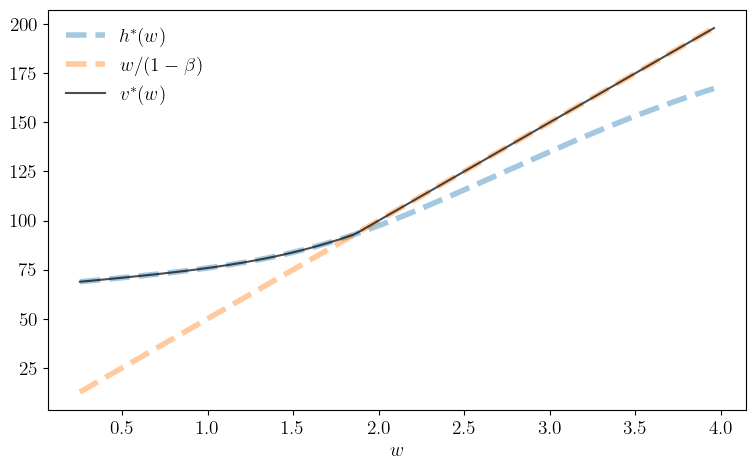

In [8]:
plot_main(savefig=True)

#### markov_js_with_sep.py

In [9]:
"""
Infinite-horizon job search with Markov wage draws and separation.

"""

from quantecon.markov import tauchen
import numpy as np
from collections import namedtuple
from s_approx import successive_approx


# NamedTuple Model
Model = namedtuple("Model", ("n", "w_vals", "P", "β", "c", "α"))


def create_js_with_sep_model(
        n=200,          # wage grid size
        ρ=0.9, ν=0.2,   # wage persistence and volatility
        β=0.98, α=0.1,  # discount factor and separation rate
        c=1.0):         # unemployment compensation
    """Creates an instance of the job search model with separation."""
    mc = tauchen(n, ρ, ν)
    w_vals, P = np.exp(mc.state_values), mc.P
    return Model(n=n, w_vals=w_vals, P=P, β=β, c=c, α=α)


def T(v, model):
    """The Bellman operator for the value of being unemployed."""
    n, w_vals, P, β, c, α = model
    d = 1 / (1 - β * (1 - α))
    accept = d * (w_vals + α * β * np.dot(P, v))
    reject = c + β * np.dot(P, v)
    return np.maximum(accept, reject)


def get_greedy(v, model):
    """ Get a v-greedy policy."""
    n, w_vals, P, β, c, α = model
    d = 1 / (1 - β * (1 - α))
    accept = d * (w_vals + α * β * np.dot(P, v))
    reject = c + β * np.dot(P, v)
    σ = accept >= reject
    return σ


def vfi(model):
    """Solve by VFI."""
    v_init = np.zeros(model.w_vals.shape)
    v_star = successive_approx(lambda v: T(v, model), v_init)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star



# == Plots == #

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.rcParams.update({"text.usetex": True, "font.size": 14})


default_model = create_js_with_sep_model()


def plot_main(model=default_model,
              savefig=False,
              figname="../figures/markov_js_with_sep_1.pdf"):
    n, w_vals, P, β, c, α = model
    v_star, σ_star = vfi(model)

    d = 1 / (1 - β * (1 - α))
    accept = d * (w_vals + α * β * np.dot(P, v_star))
    h_star = c + β * np.dot(P, v_star)

    w_star = np.inf
    for (i, w) in enumerate(w_vals):
        if accept[i] >= h_star[i]:
            w_star = w
            break

    assert w_star != np.inf, "Agent never accepts"

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(w_vals, h_star, linewidth=4, ls="--", alpha=0.4,
            label="continuation value")
    ax.plot(w_vals, accept, linewidth=4, ls="--", alpha=0.4,
            label="stopping value")
    ax.plot(w_vals, v_star, "k-", alpha=0.7, label=r"$v_u^*(w)$")
    ax.legend(frameon=False)
    ax.set_xlabel(r"$w$")
    if savefig:
        fig.savefig(figname)


def plot_w_stars(α_vals=np.linspace(0.0, 1.0, 10),
                 savefig=False,
                 figname="../figures/markov_js_with_sep_2.pdf"):

    w_star_vec = np.empty_like(α_vals)
    for (i_α, α) in enumerate(α_vals):
        print(i_α, α)
        model = create_js_with_sep_model(α=α)
        n, w_vals, P, β, c, α = model
        v_star, σ_star = vfi(model)

        d = 1 / (1 - β * (1 - α))
        accept = d * (w_vals + α * β * np.dot(P, v_star))
        h_star = c + β * np.dot(P, v_star)

        w_star = np.inf
        for (i_w, w) in enumerate(w_vals):
            if accept[i_w] >= h_star[i_w]:
                w_star = w
                break

        assert w_star != np.inf, "Agent never accepts"
        w_star_vec[i_α] = w_star

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(α_vals, w_star_vec, linewidth=2, alpha=0.6,
            label="reservation wage")
    ax.legend(frameon=False)
    ax.set_xlabel(r"$\alpha$")
    ax.set_xlabel(r"$w$")
    if savefig:
        fig.savefig(figname)

Completed iteration 25 with error 1.0768067726007686.
Completed iteration 50 with error 0.3114311653737829.
Completed iteration 75 with error 0.10927534292910934.
Completed iteration 100 with error 0.04148769976492872.
Completed iteration 125 with error 0.016208489343696897.
Completed iteration 150 with error 0.006367184136806259.
Completed iteration 175 with error 0.0025017074515147897.
Completed iteration 200 with error 0.0009893612445353028.
Completed iteration 225 with error 0.0003952811634491127.
Completed iteration 250 with error 0.00015803164485816978.
Completed iteration 275 with error 6.318165888785643e-05.
Completed iteration 300 with error 2.5260286278694366e-05.
Completed iteration 325 with error 1.0099166232180323e-05.
Completed iteration 350 with error 4.037688142943807e-06.
Completed iteration 375 with error 1.6142842866884166e-06.
Terminated successfully in 390 iterations.


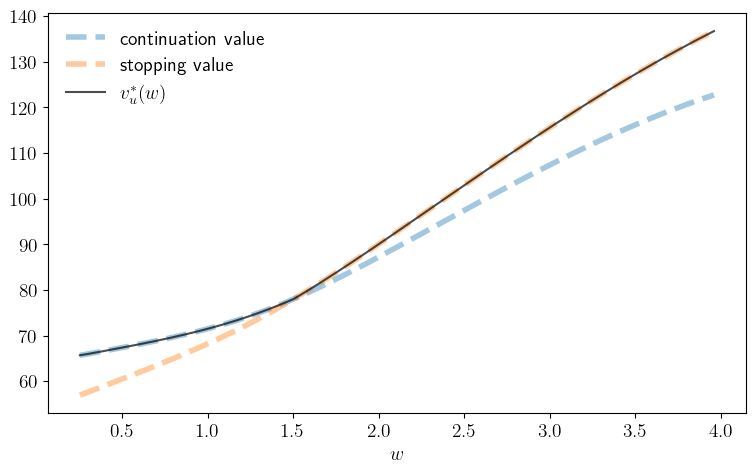

In [10]:
plot_main(savefig=True)

0 0.0
Completed iteration 25 with error 0.7358325123867075.
Completed iteration 50 with error 0.21393801675841928.
Completed iteration 75 with error 0.07487776205155683.
Completed iteration 100 with error 0.027611709626711445.
Completed iteration 125 with error 0.010342258331803578.
Completed iteration 150 with error 0.00392782716204465.
Completed iteration 175 with error 0.0014931447809374276.
Completed iteration 200 with error 0.0005676247519375011.
Completed iteration 225 with error 0.00021578485559814453.
Completed iteration 250 with error 8.203149056384973e-05.
Completed iteration 275 with error 3.118460483619856e-05.
Completed iteration 300 with error 1.1854954365730919e-05.
Completed iteration 325 with error 4.50670914631246e-06.
Completed iteration 350 with error 1.7132438188127708e-06.
Terminated successfully in 365 iterations.
1 0.1111111111111111
Completed iteration 25 with error 1.0908342197011507.
Completed iteration 50 with error 0.3207246338823424.
Completed iteration 75

Completed iteration 75 with error 0.1541702600417736.
Completed iteration 100 with error 0.06350128466103655.
Completed iteration 125 with error 0.026934357233869832.
Completed iteration 150 with error 0.01158044876807196.
Completed iteration 175 with error 0.005002636660108806.
Completed iteration 200 with error 0.00216159711674635.
Completed iteration 225 with error 0.0009340178864931659.
Completed iteration 250 with error 0.00040358577067678425.
Completed iteration 275 with error 0.0001743879643782975.
Completed iteration 300 with error 7.535241418565874e-05.
Completed iteration 325 with error 3.2559508014173844e-05.
Completed iteration 350 with error 1.4068846674319957e-05.
Completed iteration 375 with error 6.079098220368451e-06.
Completed iteration 400 with error 2.626756533175012e-06.
Completed iteration 425 with error 1.135012084318987e-06.
Terminated successfully in 430 iterations.
3 0.3333333333333333
Completed iteration 25 with error 1.0827818060272634.
Completed iteration 5

Completed iteration 450 with error 1.8371563186292406e-06.
Terminated successfully in 471 iterations.
4 0.4444444444444444
Completed iteration 25 with error 1.010106109561594.
Completed iteration 50 with error 0.48366451069682626.
Completed iteration 75 with error 0.22456412506510048.
Completed iteration 100 with error 0.1073955458537057.
Completed iteration 125 with error 0.05228381359918899.
Completed iteration 150 with error 0.025665632138021977.
Completed iteration 175 with error 0.012671593196685649.
Completed iteration 200 with error 0.00626138069863913.
Completed iteration 225 with error 0.003094052382124346.
Completed iteration 250 with error 0.0015289256308150811.
Completed iteration 275 with error 0.0007555185499654726.
Completed iteration 300 with error 0.00037333947034312587.
Completed iteration 325 with error 0.00018448568894768869.
Completed iteration 350 with error 9.116359809979713e-05.
Completed iteration 375 with error 4.5048489489829535e-05.
Completed iteration 400 w

Completed iteration 275 with error 0.0012969975859533633.
Completed iteration 300 with error 0.000676115125898491.
Completed iteration 325 with error 0.0003524537512262782.
Completed iteration 350 with error 0.00018373150076911315.
Completed iteration 375 with error 9.577785525038962e-05.
Completed iteration 400 with error 4.992827861372007e-05.
Completed iteration 425 with error 2.6027237694847827e-05.
Completed iteration 450 with error 1.3567804074909873e-05.
Completed iteration 475 with error 7.072794645068825e-06.
Completed iteration 500 with error 3.686994894280815e-06.
Completed iteration 525 with error 1.922002816456825e-06.
Completed iteration 550 with error 1.0019256606597082e-06.
Terminated successfully in 552 iterations.
6 0.6666666666666666
Completed iteration 25 with error 0.9049282870971069.
Completed iteration 50 with error 0.4935393062159861.
Completed iteration 75 with error 0.26422541561913704.
Completed iteration 100 with error 0.1422057238442207.
Completed iteration

Completed iteration 525 with error 4.599112934045024e-06.
Completed iteration 550 with error 2.5048512526382183e-06.
Completed iteration 575 with error 1.3642369651734043e-06.
Terminated successfully in 589 iterations.
7 0.7777777777777777
Completed iteration 25 with error 0.8754680641411454.
Completed iteration 50 with error 0.48591938913981636.
Completed iteration 75 with error 0.2739472364400015.
Completed iteration 100 with error 0.15435613754703326.
Completed iteration 125 with error 0.08716896006369979.
Completed iteration 150 with error 0.04929986845724699.
Completed iteration 175 with error 0.02790173261596607.
Completed iteration 200 with error 0.015807991478112626.
Completed iteration 225 with error 0.008956542454100713.
Completed iteration 250 with error 0.005074636273015187.
Completed iteration 275 with error 0.002875209574980886.
Completed iteration 300 with error 0.001629048808375444.
Completed iteration 325 with error 0.0009229935949051082.
Completed iteration 350 with e

Completed iteration 125 with error 0.09553448380319196.
Completed iteration 150 with error 0.05593656450190565.
Completed iteration 175 with error 0.03276931670900751.
Completed iteration 200 with error 0.01920113908681742.
Completed iteration 225 with error 0.01125091517433674.
Completed iteration 250 with error 0.006592479196839918.
Completed iteration 275 with error 0.0038628664157869252.
Completed iteration 300 with error 0.002263448470671392.
Completed iteration 325 with error 0.0013262687414368202.
Completed iteration 350 with error 0.0007771278194823594.
Completed iteration 375 with error 0.0004553584269402222.
Completed iteration 400 with error 0.00026681749359624973.
Completed iteration 425 with error 0.00015634184123314299.
Completed iteration 450 with error 9.160857854340065e-05.
Completed iteration 475 with error 5.3678091532560757e-05.
Completed iteration 500 with error 3.1452704035928036e-05.
Completed iteration 525 with error 1.8429727383306727e-05.
Completed iteration 5

Completed iteration 275 with error 0.004929817311051465.
Completed iteration 300 with error 0.002974970871477467.
Completed iteration 325 with error 0.0017952899930691046.
Completed iteration 350 with error 0.0010833941905588063.
Completed iteration 375 with error 0.0006537901824543724.
Completed iteration 400 with error 0.0003945393158062416.
Completed iteration 425 with error 0.0002380905616092832.
Completed iteration 450 with error 0.00014367925643199442.
Completed iteration 475 with error 8.670536367105797e-05.
Completed iteration 500 with error 5.232362886431474e-05.
Completed iteration 525 with error 3.157546456122873e-05.
Completed iteration 550 with error 1.905467919982584e-05.
Completed iteration 575 with error 1.1498826850697696e-05.
Completed iteration 600 with error 6.93913644767008e-06.
Completed iteration 625 with error 4.1875241052480305e-06.
Completed iteration 650 with error 2.5270231134300047e-06.
Completed iteration 675 with error 1.5249693348096116e-06.
Terminated s

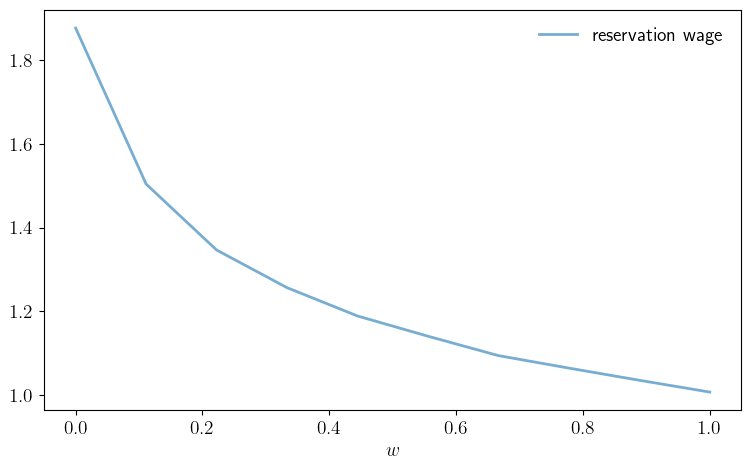

In [11]:
plot_w_stars(savefig=True)